<hr style="border:2px solid #0176DE"> </hr>
<center><h1 style="color:#173F8A;"> EMI 2024 - CMM Chile</h1></center>
<hr style="border:2px solid #0176DE"> </hr>
<h3 style="color:#173F8A;text-align:right;"> Profesores: &nbsp;Nicolás Barnafi<br>Manuel A. Sánchez<br></h3>

<h3 style="color:#03122E;text-align:right;"> 
    Centro de Modelamiento Matematico <br> 
    Instituto de Ingenieria Matematica y Computacional - IMC UC<br>  
</h3>

<hr style="border:2px solid #03122E"> </hr>
<center><h1 style="color:#173F8A;"> Modulo 3: The Conjugate Gradient Method - NGSolve</h1></center> 
<hr style="border:2px solid #03122E"> </hr>

<!-- Palette colors UC:
Primaria: 
celeste:#0176DE, azul #173F8A, azul oscuro: #03122E, amarillo: #FEC60D, amarillo oscuro: #E3AE00 
Secundaria
gris oscuro: #707070
-->

In [49]:
from ngsolve import *
from ngsolve.webgui import Draw
from ngsolve.la import EigenValues_Preconditioner
import matplotlib.pyplot as plt

## TEST 1: Model Problem the $L^2$ projection

We will test the algorithm with the solution of $L^2$ projection onto the space of continuous piecewise linear functions in $(0,1)^2$ of a function
$$ f= \sin(\pi(x-y)) $$ 

In [50]:
# Solution
mesh = Mesh(unit_square.GenerateMesh(maxh=0.05))
fes = H1(mesh, order=1)
u, v = fes.TnT()
a = BilinearForm(u*v*dx).Assemble()
f = sin(2*pi*(x-y))*cos(2*pi*(x+y))
b = LinearForm(f*v*dx).Assemble()
gfu = GridFunction(fes)
gfu.vec.data = a.mat.Inverse(freedofs=fes.FreeDofs())*b.vec
Draw(gfu)

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

BaseWebGuiScene

In [51]:
def SetL2Proj(mesh, fun=1,p=1, condense=False):
    # H1-conforming Finite Element Space
    fes = H1(mesh, order=p)
    # Trial and Test Functions
    u, v = fes.TnT()
    # Bilinear form 
    a = BilinearForm(fes, symmetric=True, condense=condense)
    a += (u*v)*dx 
    # Linear form
    b = LinearForm(fun*v*dx)
    # Gridfunction
    gfu = GridFunction(fes)
    return fes, a, b, gfu

In [52]:
def SolveL2ProjDirect(a, b, gfu, fes, condense=False):
    a.Assemble()
    b.Assemble()
    # Direct solver
    inv = a.mat.Inverse(freedofs=fes.FreeDofs(coupling=condense))
    # Solve steps depend on condense
    if condense:
        b.vec.data += a.harmonic_extension_trans * b.vec
        gfu.vec.data = inv * b.vec
        gfu.vec.data += a.harmonic_extension * gfu.vec
        gfu.vec.data += a.inner_solve * b.vec
    else: 
        gfu.vec.data = inv * b.vec
    return gfu, fes.ndof

In [53]:
def SolveL2ProjIterativeCG(a, b, gfu, fes, condense=False, compute_condnum=False):
    a.Assemble()
    b.Assemble()
    preI = Projector(mask=fes.FreeDofs(coupling=condense), range=True)
    inv = CGSolver(a.mat, pre=preI, maxsteps=10000)
    
    # Solve steps depend on condense
    if condense:
        b.vec.data += a.harmonic_extension_trans * b.vec
        gfu.vec.data = inv * b.vec
        gfu.vec.data += a.harmonic_extension * gfu.vec
        gfu.vec.data += a.inner_solve * b.vec
    else: 
        gfu.vec.data = inv * b.vec
    if compute_condnum is False:
        return gfu, inv.GetSteps()
    else:
        lams = EigenValues_Preconditioner(mat=a.mat, pre=preI)
        kappa = max(lams)/min(lams)
        return gfu, ((inv.GetSteps(), kappa))

### Test 1: parameters

In [80]:
# parametros
paramt1 = dict()
paramt1['h'] = 0.05
paramt1['f'] = sin(2*pi*(x-y))*cos(2*pi*(x+y))
paramt1['p'] = 1
paramt1['levels'] = 8 # <=8 for p=1
paramt1['h0'] = 0.05
paramt1['condense'] = False

In [81]:
mesh = Mesh(unit_square.GenerateMesh(maxh=paramt1['h']))
fes, a, b, gfu = SetL2Proj(mesh, p=paramt1['p'], fun=paramt1['f'], condense=paramt1['condense'])
gfu_direct, steps = SolveL2ProjDirect(a, b, gfu, fes, condense=paramt1['condense'])
gfu_cg, steps = SolveL2ProjIterativeCG(a, b, gfu, fes, condense=paramt1['condense'], compute_condnum=True)
print(f"number steps of CG iteration: {steps}")

number steps of CG iteration: (28, 18.736720014934324)


In [82]:
Draw(gfu_direct)
Draw(gfu_cg)

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

BaseWebGuiScene

In [44]:
from time import time

def SolveL2ProjDirect_levels(h, levels, condense=False):
    mesh = Mesh(unit_square.GenerateMesh(maxh=h))
    fes, a, b, gfu = SetL2Proj(mesh, p=paramt1['p'], fun=paramt1['f'], condense=condense)
    steps = []
    for l in range(levels):
        if l > 0: mesh.Refine()
        fes.Update()
        gfu.Update()
        with TaskManager():
            start = time()
            SolveL2ProjDirect(a, b, gfu, fes, condense=condense)
        print (f"ndof = {fes.ndof}, time = {time()-start}")
        steps.append ( (fes.ndof, time()-start) )
    return gfu, steps

_, time_direct = SolveL2ProjDirect_levels(h=paramt1['h0'], levels=paramt1['levels'], condense=paramt1['condense'])

ndof = 7633, time = 0.12765789031982422
ndof = 30209, time = 0.17353558540344238
ndof = 120193, time = 0.6198632717132568
ndof = 479489, time = 2.118124008178711


In [45]:
def SolveL2ProjIterativeCG_levels(h, levels, condense=False, compute_condnum=False):
    mesh = Mesh(unit_square.GenerateMesh(maxh=h))
    fes, a, b, gfu = SetL2Proj(mesh, p=paramt1['p'], fun=paramt1['f'], condense=condense)
    tiempo = []
    steps = []
    for l in range(levels):
        if l > 0: mesh.Refine()
        fes.Update()
        gfu.Update()
        with TaskManager():
            start = time()
            
            gfu, invsteps = SolveL2ProjIterativeCG(a, b, gfu, fes, condense=condense, compute_condnum=compute_condnum)
            print (f"ndof = {fes.ndof}, time = {time()-start}, steps = {invsteps}")
            tiempo.append ( (fes.ndof, time()-start ))
        steps.append ( (fes.ndof, invsteps ))
    return gfu, tiempo, steps

_, time_cg, steps = SolveL2ProjIterativeCG_levels(h=paramt1['h0'], levels=paramt1['levels'], condense=paramt1['condense'], compute_condnum=False)

ndof = 7633, time = 0.051859140396118164, steps = 380
ndof = 30209, time = 0.25711846351623535, steps = 400
ndof = 120193, time = 1.4472019672393799, steps = 441
ndof = 479489, time = 6.4071946144104, steps = 488


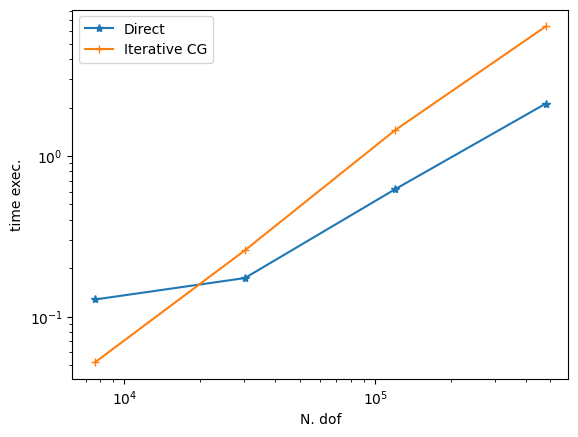

In [46]:
plt.xscale("log")
plt.yscale("log")
plt.plot(*zip(*time_direct), "-*")
plt.plot(*zip(*time_cg), "-+")
plt.legend(['Direct', 'Iterative CG'])
plt.xlabel('N. dof')
plt.ylabel('time exec.')
# plt.savefig('03_Module_Test1.png')
plt.show()

# from IPython.display import Image
# Image(filename='03_Module_Test1.png') 

In [47]:
_, _, steps = SolveL2ProjIterativeCG_levels(h=paramt1['h0'], levels=paramt1['levels'], condense=paramt1['condense'], compute_condnum=True)
ndofs = [steps[j][0] for j in range(len(steps))]
nsteps = [steps[j][1][0] for j in range(len(steps))]
kappas = [steps[j][1][1] for j in range(len(steps))]
import pandas as pd
tab = pd.DataFrame({'ndof':ndofs, 'time':np.asarray(time_cg)[:,1], 'Condition number':kappas, 'number of CG iterations': nsteps})
tab     

ndof = 7633, time = 0.051859378814697266, steps = (372, 15369.639638640117)
ndof = 30209, time = 0.3035604953765869, steps = (400, 20509.600404113295)
ndof = 120193, time = 1.4538300037384033, steps = (441, 22881.910028825034)
ndof = 479489, time = 6.3452067375183105, steps = (488, 24026.29982846714)


,ndof,time,Condition number,number of CG iterations
0,7633,0.051859,15369.639639,372
1,30209,0.258115,20509.600404,400
2,120193,1.448200,22881.910029,441
3,479489,6.408193,24026.299828,488


<hr style="border:2px solid #03122E"> </hr>

## TEST 2: Model problem the Poisson equation
We will test the algorithm in this notebook with the solution of the following Poisson problem

\begin{equation}
-\Delta u = 1, \quad \text{in } (0,1)^{2}, \qquad u=0, \quad \text{sobre } x=0 \text{ e }y=0.
\end{equation}

In [57]:
# Solution
mesh = Mesh(unit_square.GenerateMesh(maxh=0.05))
fes = H1(mesh, order=1, dirichlet='left|bottom')
u, v = fes.TnT()
a = BilinearForm(InnerProduct(grad(u), grad(v))*dx).Assemble()
b = LinearForm(1*v*dx).Assemble()
gfu = GridFunction(fes)
gfu.vec.data = a.mat.Inverse(freedofs=fes.FreeDofs())*b.vec
Draw(gfu)

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

BaseWebGuiScene

### Set Poisson problem 

In [58]:
def SetPoisson(mesh, f=1, p=1, dirichlet_bndry=None, condense=False):
    # H1-conforming Finite Element Space
    fes = H1(mesh, order=p, dirichlet=dirichlet_bndry)
    # Trial and Test Functions
    u, v = fes.TnT()
    # Bilinear form 
    a = BilinearForm(fes, symmetric=True, condense=condense)
    a += (grad(u)*grad(v))*dx 
    # Linear form
    b = LinearForm(f*v*dx)
    # Gridfunction
    gfu = GridFunction(fes)
    return fes, a, b, gfu

### Direct solver

In [59]:
def SolvePoissonDirect(a, b, gfu, fes, condense=False):
    a.Assemble()
    b.Assemble()
    # Direct solver
    inv = a.mat.Inverse(freedofs=fes.FreeDofs(coupling=condense))
    # Solve steps depend on condense
    if condense:
        b.vec.data += a.harmonic_extension_trans * b.vec
        gfu.vec.data = inv * b.vec
        gfu.vec.data += a.harmonic_extension * gfu.vec
        gfu.vec.data += a.inner_solve * b.vec
    else: 
        gfu.vec.data = inv * b.vec
    return gfu, fes.ndof

### Iterative method : Conjugate Gradient solver (no preconditioner)

In [60]:
def SolvePoissonIterativeCG(a, b, gfu, fes, condense=False, compute_condnum=False):
    a.Assemble()
    b.Assemble()
#     inv = CGSolver(a.mat, pre=NoPrec(a,fes), maxsteps=10000)
    preI = Projector(mask=fes.FreeDofs(coupling=condense), range=True)
    inv = CGSolver(a.mat, pre=preI, maxsteps=10000)
    
    # Solve steps depend on condense
    if condense:
        b.vec.data += a.harmonic_extension_trans * b.vec
        gfu.vec.data = inv * b.vec
        gfu.vec.data += a.harmonic_extension * gfu.vec
        gfu.vec.data += a.inner_solve * b.vec
    else: 
        gfu.vec.data = inv * b.vec
    if compute_condnum is False:
        return gfu, inv.GetSteps()
    else:
        lams = EigenValues_Preconditioner(mat=a.mat, pre=preI)
        kappa = max(lams)/min(lams)
        return gfu, ((inv.GetSteps(), kappa))

In [61]:
# class Preconditioner identity
class NoPrec(BaseMatrix):
    def __init__ (self, a, fes):
        super(NoPrec, self).__init__()
        self.a = a
        self.fes = fes
    def Mult (self, x, y):
        y[:] = 0.0
        FreeDofsindex = np.where(self.fes.FreeDofs())[0]
        y.FV().NumPy()[FreeDofsindex] = x.FV().NumPy()[FreeDofsindex]
    def Height (self):
        return self.a.mat.shape[0]
    def Width (self):
        return self.a.mat.shape[1]

### TEST 2 parameters 

In [83]:
# parameters
paramt2 = dict()
paramt2['h'] = 0.05
paramt2['f'] = 1
paramt2['p'] = 1 # p = 6 try h0=0.25
paramt2['h0'] = 0.05
paramt2['levels'] = 6 # <=6 if p=1
paramt2['condense'] = False # True does not work

In [84]:
# Mesh
mesh = Mesh(unit_square.GenerateMesh(maxh=paramt2['h']))
# Set Poisson
fes, a, b, gfu = SetPoisson(mesh, p=paramt2['p'], f=paramt2['f'], dirichlet_bndry='bottom|left', condense=paramt2['condense'])
# Solve direct method
gfu_direct, steps = SolvePoissonDirect(a, b, gfu, fes, condense=paramt2['condense'])
# Solve iterative method
gfu_cg, steps = SolvePoissonIterativeCG(a, b, gfu, fes, condense=paramt2['condense'], compute_condnum=True)
print(f"number steps of CG iteration: {steps}")

number steps of CG iteration: (86, 546.9259251740789)


In [85]:
Draw(gfu_direct)
Draw(gfu_cg)

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

BaseWebGuiScene

### Solving for a sequence of meshes

In [86]:
from time import time
def SolvePoissonDirect_levels(h, levels, condense=False):
    mesh = Mesh(unit_square.GenerateMesh(maxh=h))
    fes, a, b, gfu = SetPoisson(mesh, p =paramt2['p'], dirichlet_bndry='bottom|left', condense=condense)
    steps = []
    for l in range(levels):
        if l > 0: mesh.Refine()
        fes.Update()
        gfu.Update()
        with TaskManager():
            start = time()
            gfu,_ = SolvePoissonDirect(a, b, gfu, fes, condense=condense)
        print (f"ndof = {fes.ndof}, time = {time()-start}")
        steps.append ( (fes.ndof, time()-start) )
    return gfu, steps

_, time_direct = SolvePoissonDirect_levels(h=paramt2['h0'], levels=paramt2['levels'], condense=paramt2['condense'])

ndof = 508, time = 0.005957841873168945
ndof = 1949, time = 0.02407693862915039
ndof = 7633, time = 0.03116321563720703
ndof = 30209, time = 0.1543741226196289
ndof = 120193, time = 0.40172743797302246
ndof = 479489, time = 1.8292157649993896


In [87]:
def SolvePoissonIterativeCG_levels(h, levels, condense=False, compute_condnum=False):
    mesh = Mesh(unit_square.GenerateMesh(maxh=h))
    fes, a, b, gfu = SetPoisson(mesh, p=paramt2['p'], dirichlet_bndry='bottom|left', condense=condense)
    tiempo = []
    steps = []
    for l in range(levels):
        if l > 0: mesh.Refine()
        fes.Update()
        gfu.Update()
        with TaskManager():
            start = time()
            gfu, invsteps = SolvePoissonIterativeCG(a, b, gfu, fes, condense=condense, compute_condnum=compute_condnum)
            print (f"ndof = {fes.ndof}, time = {time()-start}, steps = {invsteps}")
            tiempo.append ( (fes.ndof, time()-start ))
        steps.append ( (fes.ndof, invsteps ))
    return gfu, tiempo, steps

_, time_cg, steps = SolvePoissonIterativeCG_levels(h=paramt2['h0'], levels=paramt2['levels'], condense=paramt2['condense'], compute_condnum=False)

ndof = 508, time = 0.0019948482513427734, steps = 86
ndof = 1949, time = 0.006980180740356445, steps = 224
ndof = 7633, time = 0.025361299514770508, steps = 442
ndof = 30209, time = 0.16385912895202637, steps = 885
ndof = 120193, time = 1.524554967880249, steps = 1780
ndof = 479489, time = 21.78961420059204, steps = 3595


### Comparison plot of execution times

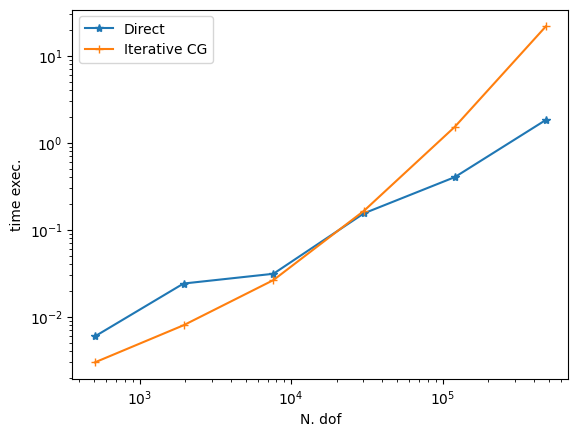

In [88]:
plt.xscale("log")
plt.yscale("log")
plt.plot(*zip(*time_direct), "-*")
plt.plot(*zip(*time_cg), "-+")
plt.legend(['Direct', 'Iterative CG'])
plt.xlabel('N. dof')
plt.ylabel('time exec.')
# plt.savefig('03_Module_Test2.png')
plt.show()

# from IPython.display import Image
# Image(filename='03_Module_Test2.png') 

In [89]:
_, _, steps = SolvePoissonIterativeCG_levels(h=paramt2['h0'], levels=paramt2['levels'], condense=False, compute_condnum=True)
ndofs = [steps[j][0] for j in range(len(steps))]
nsteps = [steps[j][1][0] for j in range(len(steps))]
kappas = [steps[j][1][1] for j in range(len(steps))]
import pandas as pd
tab = pd.DataFrame({'ndof':ndofs, 'time':np.asarray(time_cg)[:,1], 'Condition number':kappas, 'number of CG iterations': nsteps})
tab     

ndof = 508, time = 0.004109621047973633, steps = (86, 547.32006770656)
ndof = 1949, time = 0.010968685150146484, steps = (224, 3154.4513407354984)
ndof = 7633, time = 0.030140399932861328, steps = (442, 7364.181608004097)
ndof = 30209, time = 0.17490434646606445, steps = (885, 15763.57464937753)
ndof = 120193, time = 1.6745758056640625, steps = (1780, 31562.104258009364)
ndof = 479489, time = 24.904078245162964, steps = (3595, 62213.888163090305)


,ndof,time,Condition number,number of CG iterations
0,508,0.002992,547.320068,86
1,1949,0.007978,3154.451341,224
2,7633,0.026360,7364.181608,442
3,30209,0.164856,15763.574649,885
4,120193,1.525553,31562.104258,1780
5,479489,21.790612,62213.888163,3595
